# Performing Exploratory Data Analysis for Student Retention

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats

from tools.utils import combine_columns, compute_feature_importance, standard_units

## Introduction

The purpose of this project is to analyze the factors that influence the retention rate of a school and how closely they relate to retention rate. Retention rate is a critical indicator of a school's effectiveness and success in keeping students enrolled and engaged in their academic pursuits. In this project, we will examine various factors that could potentially impact retention rates, such as the control of the school(public, non-profit private and profit private), in-state/out-state tuition & fee, the percentage of individuals receiving federal loans, race, parent education and so on.

## Data Description

The data used in this analysis will be obtained from the College Scorecard, a comprehensive dataset maintained by the United States Department of Education. The dataset includes information on over 7,000 higher education institutions in the United States, spanning a period of more than two decades.

The dataset includes a range of variables, including institutional characteristics such as size, location, and type of degree programs offered, as well as information on student outcomes such as graduation rates, earnings, and debt levels. In addition, the dataset includes information on institutional net price, which is the average cost of attendance after accounting for grants and scholarships.

Overall, the data provides a comprehensive view of the factors that impact retention rates in higher education institutions and will be used to inform strategies for improving retention rates and student success.

## Loading in Data

In [13]:
# Load in cleaned data
data = pd.read_csv("data/Most-Recent-Cohorts-Institution-filtered.csv")
data = data.drop('Unnamed: 0', axis=1)

Since we are focusing on retention rates, we are renaming the variable names for the "First-time, full-time student retention rate at four-year institutions" and "First-time, full-time student retention rate at less-than-four-year institutions" in order to improve identification of the main variables.

In [29]:
# First-time, full-time student retention rate at four-year institutions
four_yr_retention = data.RET_FT4

# First-time, full-time student retention rate at less-than-four-year institutions
less_four_yr_retention = data.RET_FTL4

## Important Note: __Null Values__

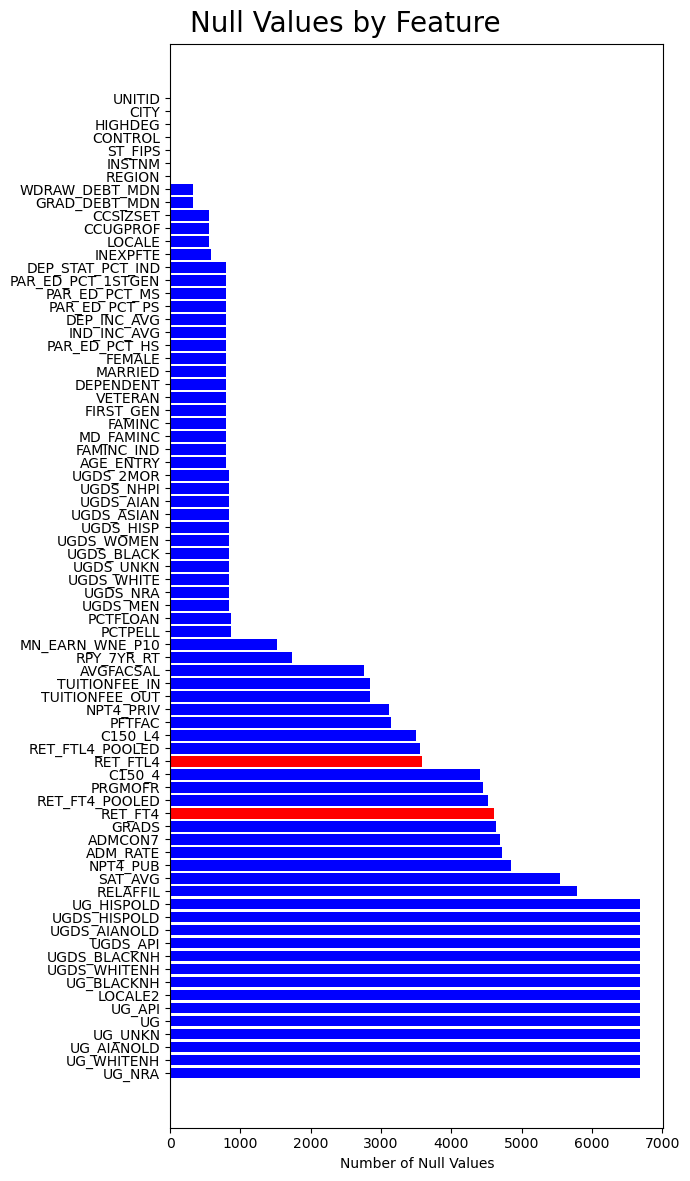

In [32]:
nulls_by_column = data.isna().sum().sort_values(ascending=False)

colors = np.tile('b', len(nulls_by_column))

retention = ["RET_FT4", "RET_FTL4"]
retention_vars_mask = pd.Series(nulls_by_column.index).isin(retention).values
colors[retention_vars_mask] = np.tile('r', len(retention))

fig, ax = plt.subplots(figsize=(7, 12))
ax.barh(np.arange(-5, len(nulls_by_column)-5), nulls_by_column.values, color=colors)
ax.set_yticks(np.arange(-5, len(nulls_by_column)-5), labels=nulls_by_column.index)
ax.set_xlabel("Number of Null Values")
fig.suptitle("Null Values by Feature", size=20)
fig.savefig('figures/null_values.png')
fig.tight_layout();

It is important to note that we will be dealing with a high amount of null values, especially when looking at the number of programs. In fact, the last several columns listed are entirely null.

## Histograms for Retention Rates

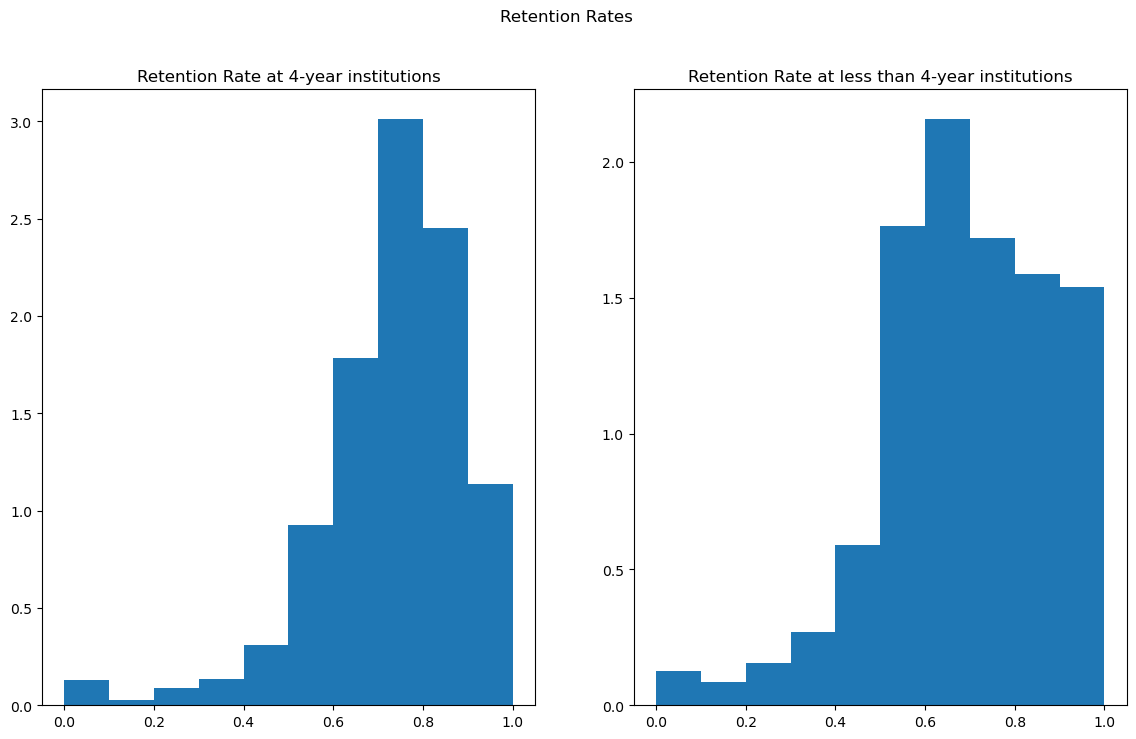

<Figure size 1400x800 with 0 Axes>

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Retention Rates')

ax1.set_title('Retention Rate at 4-year institutions')
ax1.hist(four_yr_retention, density = True)

ax2.set_title('Retention Rate at less than 4-year institutions')
ax2.hist(less_four_yr_retention, density = True)

plt.show()
plt.savefig('figures/overall_retention_histogram.png')

Based on the histograms, we notice that retention rates for both 4-year and less than 4-year institutions appear to have a left-skewed distribution. However, less than 4-year institutions has more density contained within the higher retention rates compared to the 4-year institutions.

We will now explore sets of relevant variables and their relation to the retention rates.

## Explore the control of the school

#### Public Schools

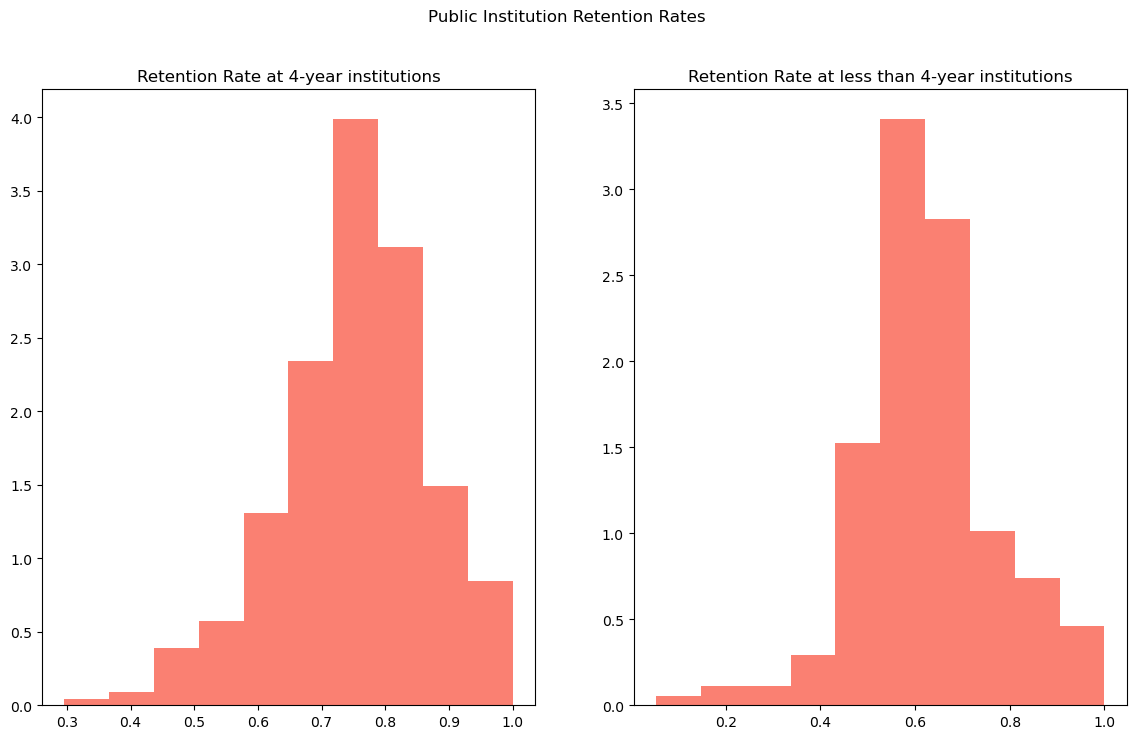

<Figure size 1400x800 with 0 Axes>

In [34]:
public = data.loc[data["CONTROL"] == 1]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Public Institution Retention Rates')

ax1.set_title('Retention Rate at 4-year institutions')
ax1.hist(public.RET_FT4, density = True, color = "salmon")

ax2.set_title('Retention Rate at less than 4-year institutions')
ax2.hist(public.RET_FTL4, density = True, color = "salmon")

plt.show()
plt.savefig('figures/retention_public.png')

For public schools, the retention rates severely declines as the left-skewed distribution transforms into a normal distribution. The change is more noticeable in the retention rates of less than 4-year public institutions.

#### Private Non-Profit

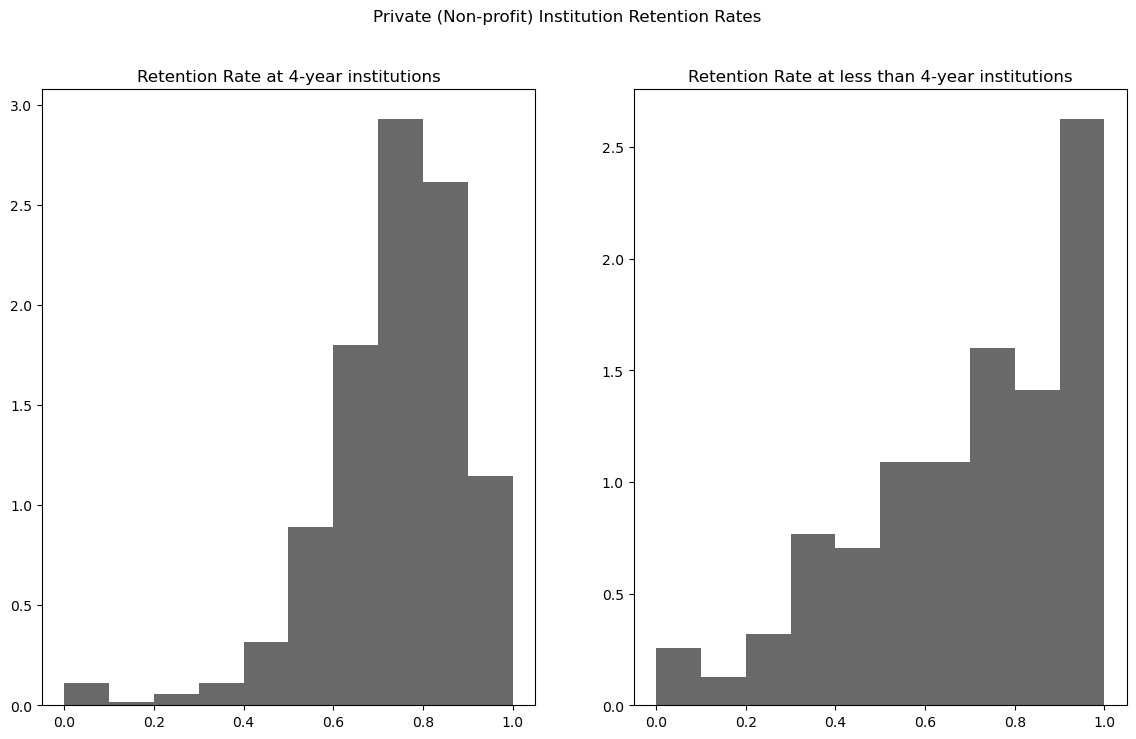

<Figure size 1400x800 with 0 Axes>

In [37]:
private_non_profit = data.loc[data["CONTROL"] == 2]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Private (Non-profit) Institution Retention Rates')

ax1.set_title('Retention Rate at 4-year institutions')
ax1.hist(private_non_profit.RET_FT4, density = True, color = "dimgray")

ax2.set_title('Retention Rate at less than 4-year institutions')
ax2.hist(private_non_profit.RET_FTL4, density = True, color = "dimgray")

plt.show()
plt.savefig('figures/retention_private_non_profit.png')

In the case of non-profit private institutions, the retention rates for 4-year institutions appears to remain with the same. However, the retention for less than 4-year institution increases with the density focused in the 100% retention rate. 

#### Private For-Profit

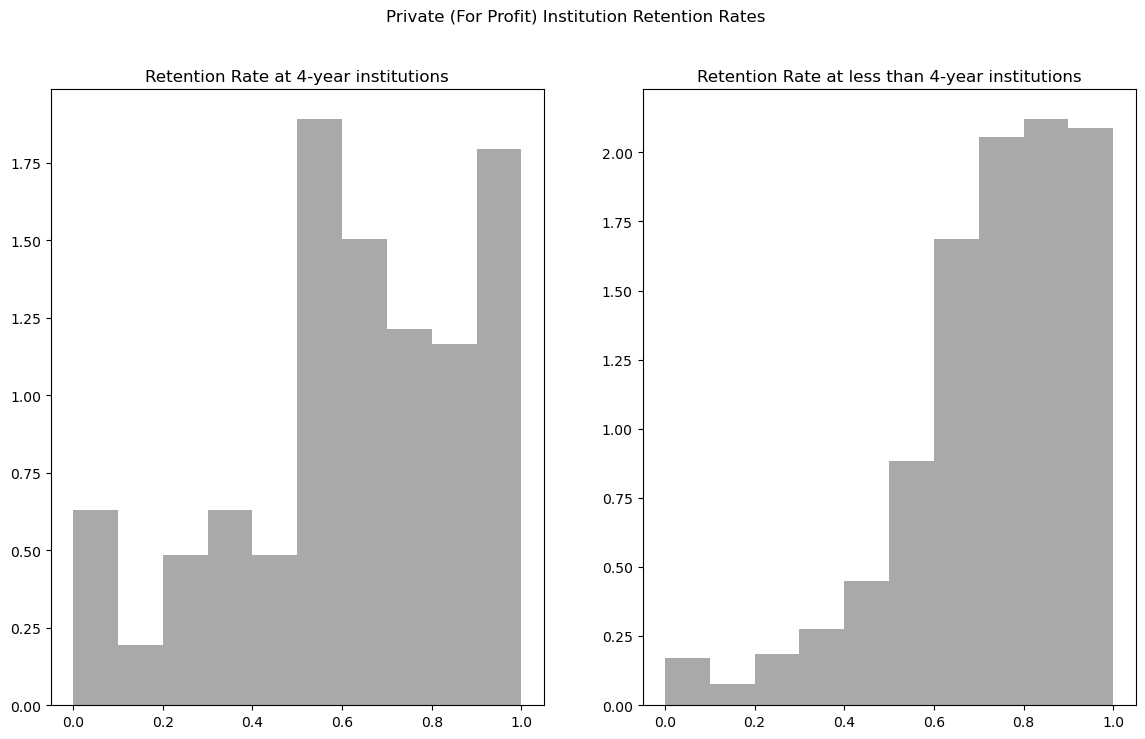

<Figure size 1400x800 with 0 Axes>

In [38]:
private_profit = data.loc[data["CONTROL"] == 3]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Private (For Profit) Institution Retention Rates')

ax1.set_title('Retention Rate at 4-year institutions')
ax1.hist(private_profit.RET_FT4, density = True, color = "darkgray")

ax2.set_title('Retention Rate at less than 4-year institutions')
ax2.hist(private_profit.RET_FTL4, density = True, color = "darkgray")

plt.show()
plt.savefig('figures/retention_private_profit.png')

As for-profit private institutions, the retention rate for 4-year institutions maintains a left skewed distribution. However, a spike appears around the the 50% mark which indicates a slightly worse retention than the overall. As for the less than 4-year institution, the retention increases similarly to the non-profit institution as the density is focused on the higher end of the retention rates.

## Explore In-state and Out-state Tuition & Fee

In [39]:
# data only with tuition fee of in state and out state, four-year institutions and less than four-year institutions
tuition_data = data[['RET_FT4', 'RET_FTL4', 'TUITIONFEE_IN','TUITIONFEE_OUT']]
tuition_data.head()

,RET_FT4,RET_FTL4,TUITIONFEE_IN,TUITIONFEE_OUT
0,0.5403,NaN,10024.0,18634.0
1,0.8640,NaN,8568.0,20400.0
2,0.5000,NaN,6950.0,6950.0
3,0.8180,NaN,11338.0,23734.0
4,0.6202,NaN,11068.0,19396.0


First, we can take a look at what difference in the distribution between in-state and out-state tuition.

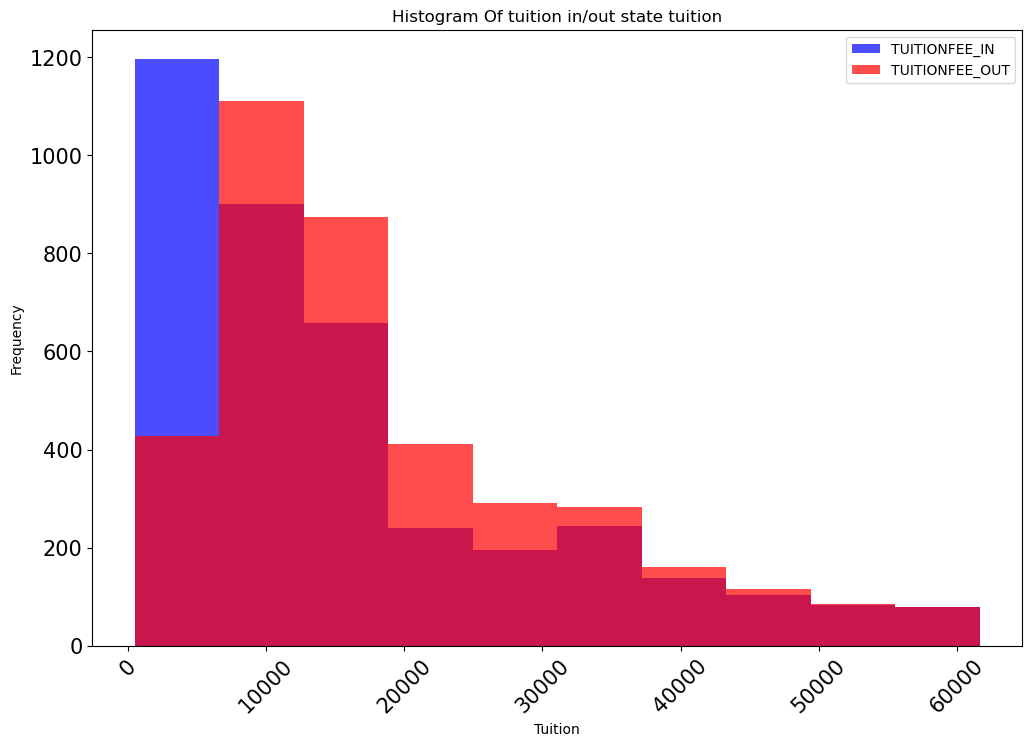

<Figure size 1400x800 with 0 Axes>

In [40]:
tuition_data_inout = tuition_data[['TUITIONFEE_IN','TUITIONFEE_OUT']]
tuition_data_inout.plot(kind='hist',
        alpha=0.7,
        title='Histogram Of tuition in/out state tuition',
        rot=45,
        figsize=(12,8),
        fontsize=15, 
        color=['blue', 'r'])
plt.xlabel('Tuition');

plt.show()
plt.savefig('figures/in_out_tuition.png')

From the Histogram above, in state more concentrated in the low cost segment. And more people are out of state than in state in every range except 0 to 5,000. It can be seen that students out of state need to pay more fees than those in state. The same conclusion can be found when we directly compare the mean and median of students in state and out state, that is, both the mean and median of students in out state are higher than those in state.

After looking at the difference in distribution between in state tuition & fee and out state tuition & fee, we can analysis them combine with retention rate. Now take a look at if in/out state tuition&fee affect retention rate.

In [41]:
in_FT4 = data[['RET_FT4', 'TUITIONFEE_IN']]
in_FTL4 = data[['RET_FTL4', 'TUITIONFEE_IN']]
out_FT4 = data[['RET_FT4', 'TUITIONFEE_OUT']]
out_FTL4 = data[['RET_FTL4', 'TUITIONFEE_OUT']]

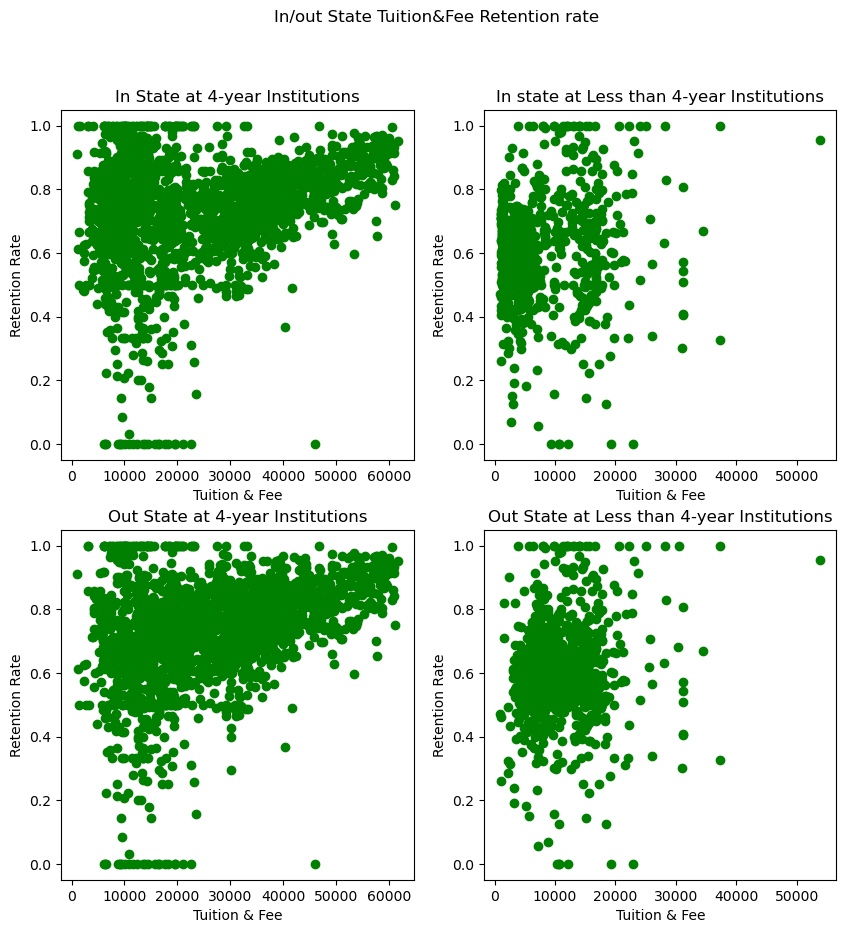

<Figure size 1400x800 with 0 Axes>

In [42]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle('In/out State Tuition&Fee Retention rate')

# make a graph for in state tuition & fee and 4 year institutions
ax1.set_title('In State at 4-year Institutions')
ax1.set_xlabel('Tuition & Fee')
ax1.set_ylabel('Retention Rate')
ax1.scatter(in_FT4.TUITIONFEE_IN, in_FT4.RET_FT4,color ='green')

# make a graph for in state tuition & fee and less than 4 year institutions
ax2.set_title('In state at Less than 4-year Institutions')
ax2.set_xlabel('Tuition & Fee')
ax2.set_ylabel('Retention Rate')
ax2.scatter(in_FTL4.TUITIONFEE_IN, in_FTL4.RET_FTL4,color ='green')

# make a graph for out state tuition & fee and 4 year institutions
ax3.set_title('Out State at 4-year Institutions')
ax3.set_xlabel('Tuition & Fee')
ax3.set_ylabel('Retention Rate')
ax3.scatter(out_FT4.TUITIONFEE_OUT, out_FT4.RET_FT4,color ='green')

# make a graph for out state tuition & fee and less than 4 year institutions
ax4.set_title('Out State at Less than 4-year Institutions')
ax4.set_xlabel('Tuition & Fee')
ax4.set_ylabel('Retention Rate')
ax4.scatter(out_FTL4.TUITIONFEE_OUT, out_FTL4.RET_FTL4,color ='green')

plt.show()
plt.savefig('figures/retention_in_out_tuition.png')

We use the correlation coefficient(r) measures the strength of the linear relationship between two variables. Graphically, it measures how clustered the scatter diagram is around a straight line.

In [43]:
standard_tuition_data = tuition_data.assign(standard_RET_FT4=standard_units(tuition_data.RET_FT4),
                       standard_RET_FTL4=standard_units(tuition_data.RET_FTL4),
                       standard_TUI_IN=standard_units(tuition_data.TUITIONFEE_IN),
                       standard_TUI_OUT=standard_units(tuition_data.TUITIONFEE_OUT))
standard_tuition_data.head()

,RET_FT4,RET_FTL4,TUITIONFEE_IN,TUITIONFEE_OUT,standard_RET_FT4,standard_RET_FTL4,standard_TUI_IN,standard_TUI_OUT
0,0.5403,NaN,10024.0,18634.0,-1.139438,NaN,-0.422876,-0.038961
1,0.8640,NaN,8568.0,20400.0,0.794970,NaN,-0.526098,0.095119
2,0.5000,NaN,6950.0,6950.0,-1.380268,NaN,-0.640805,-0.926044
3,0.8180,NaN,11338.0,23734.0,0.520077,NaN,-0.329721,0.348246
4,0.6202,NaN,11068.0,19396.0,-0.661961,NaN,-0.348862,0.018892


In [44]:
# the correlation coefficient(r) of 4-year instituion with in-state tuition
r_4_in_state = np.mean(standard_tuition_data.standard_RET_FT4 * standard_tuition_data.standard_TUI_IN)
# the correlation coefficient(r) of 4-year instituion with out-state tuition
r_4_out_state = np.mean(standard_tuition_data.standard_RET_FT4 * standard_tuition_data.standard_TUI_OUT)
# the correlation coefficient(r) of less than 4-year instituion with in-state tuition
r_less_4_in_state = np.mean(standard_tuition_data.standard_RET_FTL4 * standard_tuition_data.standard_TUI_IN)
# the correlation coefficient(r) of less than 4-year instituion with out-state tuition
r_less_4_out_state = np.mean(standard_tuition_data.standard_RET_FTL4 * standard_tuition_data.standard_TUI_OUT)

print("The correlation coefficient of 4-year instution for in-state tuition & fee is " + str(r_4_in_state)+".")
print("The correlation coefficient of 4-year instution for out-state tuition & fee is " + str(r_4_out_state)+ ".")
print("The correlation coefficient of less than 4-year instution for in-state tuition & fee is "+ str(r_less_4_in_state)+".")
print("The correlation coefficient of less than 4-year instution for out-state tuition & fee is "+ str(r_less_4_out_state)+".")

The correlation coefficient of 4-year instution for in-state tuition & fee is 0.27829321886510244.
The correlation coefficient of 4-year instution for out-state tuition & fee is 0.3726884580745627.
The correlation coefficient of less than 4-year instution for in-state tuition & fee is 0.32978043799834184.
The correlation coefficient of less than 4-year instution for out-state tuition & fee is 0.3277732356542793.


Based on the correlation coefficient, there is a weak relationship between in/out-state tuition&fee with retention rate at either four-year and less-than-four-year institutions.

## Explore Percentage of individuals receiving federal loans

Now we will focus on if the percent of all undergraduate students receiving federal student loan affect the the "First-time, full-time student retention rate at four-year institutions" and "First-time, full-time student retention rate at less-than-four-year institutions". We can filter out the related data.

In [45]:
# data only with tuition fee of in state and out state, four-year institutions and less than four-year institutions
percent_loan_data = data[['RET_FT4', 'RET_FTL4', 'PCTFLOAN']]
percent_loan_data.head()

,RET_FT4,RET_FTL4,PCTFLOAN
0,0.5403,NaN,0.7504
1,0.8640,NaN,0.4688
2,0.5000,NaN,0.8493
3,0.8180,NaN,0.3855
4,0.6202,NaN,0.7805


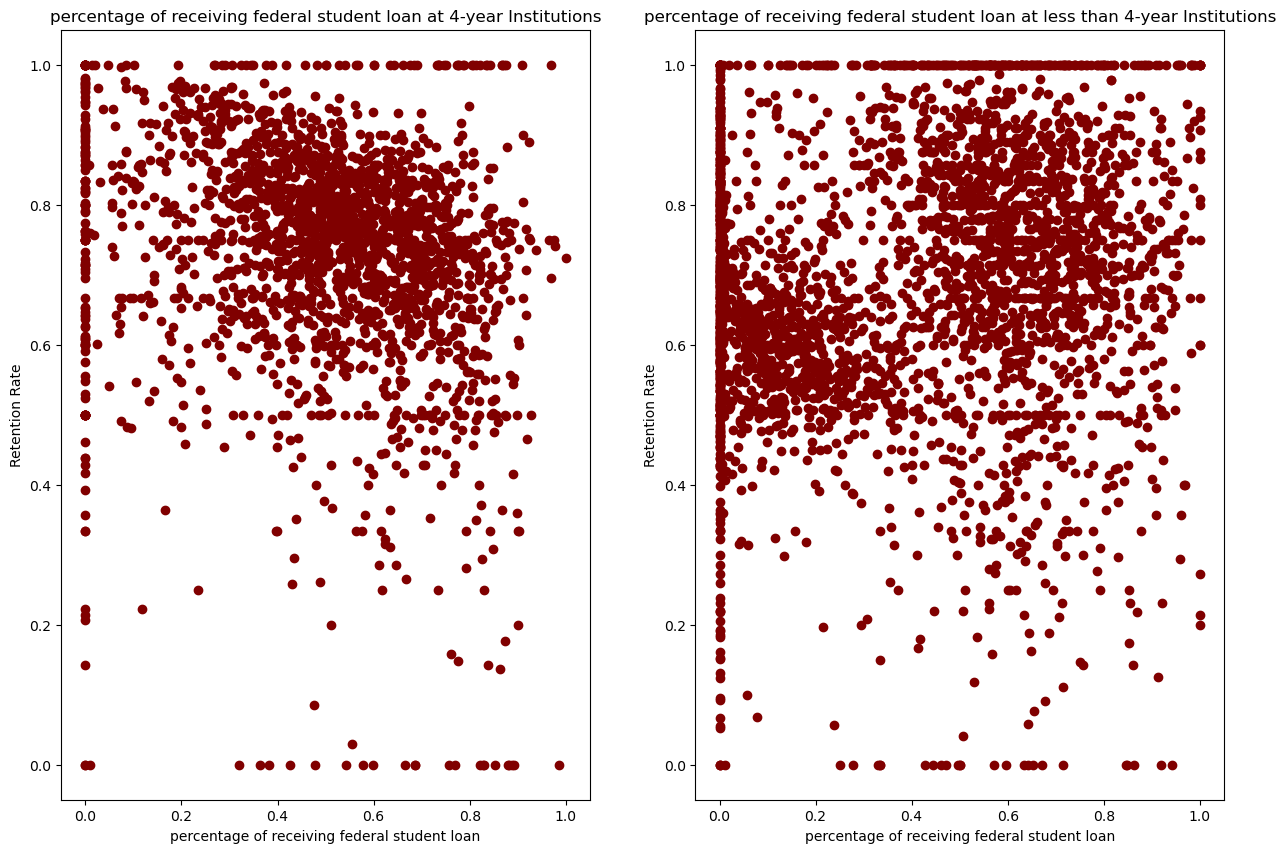

<Figure size 1400x800 with 0 Axes>

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,10))
fig.suptitle('')

ax1.set_title('percentage of receiving federal student loan at 4-year Institutions')
ax1.set_xlabel('percentage of receiving federal student loan')
ax1.set_ylabel('Retention Rate')
ax1.scatter(percent_loan_data.PCTFLOAN, percent_loan_data.RET_FT4,color ='maroon')

ax2.set_title('percentage of receiving federal student loan at less than 4-year Institutions')
ax2.set_xlabel('percentage of receiving federal student loan')
ax2.set_ylabel('Retention Rate')
ax2.scatter(percent_loan_data.PCTFLOAN, percent_loan_data.RET_FTL4,color ='maroon')

plt.show()
plt.savefig('figures/retention_percentage_federal_loan.png')

In [47]:
standard_percent_loan_data = tuition_data.assign(standard_RET_FT4=standard_units(percent_loan_data.RET_FT4),
                       standard_RET_FTL4=standard_units(percent_loan_data.RET_FTL4),
                       standard_percent_loan=standard_units(percent_loan_data.PCTFLOAN))
standard_percent_loan_data
# the correlation coefficient(r) of percentage of receiving federal student loan at 4-year Institutions
r_percent_loan_4year = np.mean(standard_percent_loan_data.standard_RET_FT4 * standard_percent_loan_data.standard_percent_loan)
print("The correlation coefficient of percentage of receiving federal student loan at 4-year Institutions is "+ str(r_percent_loan_4year))
# the correlation coefficient(r) of percentage of receiving federal student loan at less than 4-year Institutions
r_percent_loan_l4year = np.mean(standard_percent_loan_data.standard_RET_FTL4 * standard_percent_loan_data.standard_percent_loan)
print("The correlation coefficient of percentage of receiving federal student loan at less than 4-year Institutions is "+str(r_percent_loan_l4year))

The correlation coefficient of percentage of receiving federal student loan at 4-year Institutions is -0.1654776936242682
The correlation coefficient of percentage of receiving federal student loan at less than 4-year Institutions is 0.14346890122719802


By the scatter above and the correlation coefficient,we think the percentage of receiving federal student loan at 4-year Institutions and less than 4-year Institutions graph looks like not really match the positive or negative relationship with retention rate. Therefore, we think the percentage of receiving federal student loan at 4-year or less than 4-year Institutions not really influence student's retention rate.

## Feature Analysis on Numerical variables (not including "Privacy Suppressed" variables)

In [ ]:
fouryr_features = ['HIGHDEG', 'ADM_RATE', 'ST_FIPS', 'LOCALE', 'SAT_AVG', 'CCUGPROF', 'CCSIZSET',
            'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN' , 
            'UGDS_NHPI', 'UGDS_2MOR', 'UGDS_NRA','UGDS_UNKN', 
            'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'INEXPFTE', 'AVGFACSAL' , 'PFTFAC',
            'PCTPELL', 'PCTFLOAN', 'AGE_ENTRY', 
            'FAMINC','MD_FAMINC', 'ADMCON7', 'UGDS_MEN', 'UGDS_WOMEN', 'ANP',
            ## four year specific
            'RET_FT4']

clean_data = combine_columns(data, 'NPT4_PUB', 'NPT4_PRIV', 'ANP')[fouryr_features].dropna()

In [ ]:
compute_feature_importance(clean_data, 'RET_FT4')

,Feature,Importance
4,SAT_AVG,0.225643
19,AVGFACSAL,0.133965
24,FAMINC,0.062228
21,PCTPELL,0.062037
5,CCUGPROF,0.060383
6,CCSIZSET,0.049620
10,UGDS_ASIAN,0.040125
25,MD_FAMINC,0.029388
18,INEXPFTE,0.025987
17,TUITIONFEE_OUT,0.019062


Based on the feature analysis with four-year retention rates, `SAT_AVG` and `AVGFASCAL` have some importance in determining retention rates.

In [ ]:
less_fouryr_features = ['HIGHDEG', 'ADM_RATE', 'ST_FIPS', 'LOCALE', 'SAT_AVG', 'CCUGPROF', 'CCSIZSET',
            'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN' , 
            'UGDS_NHPI', 'UGDS_2MOR', 'UGDS_NRA','UGDS_UNKN', 
            'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'INEXPFTE', 'AVGFACSAL' , 'PFTFAC',
            'PCTPELL', 'PCTFLOAN', 'AGE_ENTRY', 
            'FAMINC','MD_FAMINC', 'ADMCON7', 'UGDS_MEN', 'UGDS_WOMEN', 'ANP',
            ## less than four year specific
            'RET_FTL4']

clean_data = combine_columns(data, 'NPT4_PUB', 'NPT4_PRIV', 'ANP')[less_fouryr_features].dropna()

In [ ]:
compute_feature_importance(clean_data, 'RET_FTL4')

,Feature,Importance
9,UGDS_HISP,0.128479
11,UGDS_AIAN,0.122401
5,CCUGPROF,0.119550
18,INEXPFTE,0.079287
8,UGDS_BLACK,0.077447
12,UGDS_NHPI,0.075504
14,UGDS_NRA,0.062974
16,TUITIONFEE_IN,0.041554
13,UGDS_2MOR,0.037260
15,UGDS_UNKN,0.026139


Based on the feature analysis with less-than-four-year retention rates, the diversity of ethnicity and `CCUGPROF` have some importance in determining retention rates.